In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import cartopy as cart
import cartopy.crs as ccrs

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

## Define the section lines 

In [4]:
ptDaS1,ptDaS2 = ecco.get_section_endpoints('Davis Strait')
ptDeS1,ptDeS2 = ecco.get_section_endpoints('Denmark Strait')
ptIF1,ptIF2 = ecco.get_section_endpoints('Iceland Faroe')
ptFS1,ptFS2 = ecco.get_section_endpoints('Faroe Scotland')
ptSN1,ptSN2 = ecco.get_section_endpoints('Scotland Norway')
ptFrS1,ptFrS2 = ecco.get_section_endpoints('Fram Strait')
ptSvN1,ptSvN2 = ecco.get_section_endpoints('Barents Sea')
ptLG1,ptLG2 = ecco.get_section_endpoints('Labrador Greenland')
ptHS1,ptHS2 = ecco.get_section_endpoints('Hudson Strait')
ptEC1,ptEC2 = ecco.get_section_endpoints('English Channel')
ptNI1,ptNI2 = ecco.get_section_endpoints('Newfoundland Iberia')

maskC_DaS, maskW_DaS, maskS_DaS = ecco.get_section_line_masks(ptDaS1,ptDaS2,main)
maskC_DeS, maskW_DeS, maskS_DeS = ecco.get_section_line_masks(ptDeS1,ptDeS2,main)
maskC_IF, maskW_IF, maskS_IF = ecco.get_section_line_masks(ptIF1,ptIF2,main)
maskC_FS, maskW_FS, maskS_FS = ecco.get_section_line_masks(ptFS1,ptFS2,main)
maskC_SN, maskW_SN, maskS_SN = ecco.get_section_line_masks(ptSN1,ptSN2,main)
maskC_FrS, maskW_FrS, maskS_FrS = ecco.get_section_line_masks(ptFrS1,ptFrS2,main)
maskC_SvN, maskW_SvN, maskS_SvN = ecco.get_section_line_masks(ptSvN1,ptSvN2,main)
maskC_LG, maskW_LG, maskS_LG = ecco.get_section_line_masks(ptLG1,ptLG2,main)
maskC_HS, maskW_HS, maskS_HS = ecco.get_section_line_masks(ptHS1,ptHS2,main)
maskC_EC, maskW_EC, maskS_EC = ecco.get_section_line_masks(ptEC1,ptEC2,main)
maskC_NI, maskW_NI, maskS_NI = ecco.get_section_line_masks(ptNI1,ptNI2,main)

In [5]:
maskC_tot = (maskC_DaS + maskC_DeS + maskC_IF + maskC_FS + maskC_SN + maskC_HS + maskC_NI + maskC_FrS\
             + maskC_SvN + maskC_EC + maskC_LG)\
            .where(maskC_DaS + maskC_DeS + maskC_IF + maskC_FS + maskC_SN + maskC_HS + maskC_NI\
                   + maskC_FrS + maskC_SvN + maskC_EC +maskC_LG==1,0)

maskW_tot = (maskW_DaS + maskW_DeS + maskW_IF + maskW_FS + maskW_SN + maskW_HS + maskW_NI + maskW_FrS\
             + maskW_SvN + maskW_EC + maskW_LG)\
            .where(np.abs(maskW_DaS) + np.abs(maskW_DeS) + np.abs(maskW_IF) + np.abs(maskW_FS) + np.abs(maskW_SN)\
                   + np.abs(maskW_HS) + np.abs(maskW_NI) + np.abs(maskW_FrS) + np.abs(maskW_SvN)\
                   + np.abs(maskW_EC) + np.abs(maskW_LG)==1,0)

maskS_tot=(maskS_DaS + maskS_DeS + maskS_IF + maskS_FS + maskS_SN + maskS_HS + maskS_NI + maskS_FrS\
           + maskS_SvN + maskS_EC + maskS_LG)\
            .where(np.abs(maskS_DaS) + np.abs(maskS_DeS) + np.abs(maskS_IF) + np.abs(maskS_FS) + np.abs(maskS_SN)\
                   + np.abs(maskS_HS) + np.abs(maskS_NI) + np.abs(maskS_FrS) + np.abs(maskS_SvN)\
                   + np.abs(maskS_EC)+ np.abs(maskS_LG)==1,0)

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [9]:
main.XC

<xarray.DataArray 'XC' (tile: 13, j: 90, i: 90)>
dask.array<zarr, shape=(13, 90, 90), dtype=float32, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    CS       (tile, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth    (tile, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SN       (tile, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    XC       (tile, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    rA       (tile, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
Attributes:
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

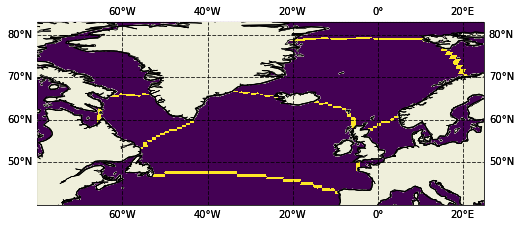

In [18]:
plt.figure(figsize=(8,8))
# use dx=.1, dy=.1 so that plot shows the osnap array as a thin 
# line.  remember, plot_proj_to_latlon_grid first interpolates
# the model grid to lat-lon with grid spacing as dx, dy
p = ecco.plot_proj_to_latlon_grid(main.XC, main.YC, maskC_tot, cmap='viridis',
                                  projection_type='PlateCarree', dx=.1, dy=.1)

#ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
p[1].set_extent([-80, 25, 40, 83], crs=ccrs.PlateCarree())
plt.show()

In [19]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [20]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [21]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:

In [22]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



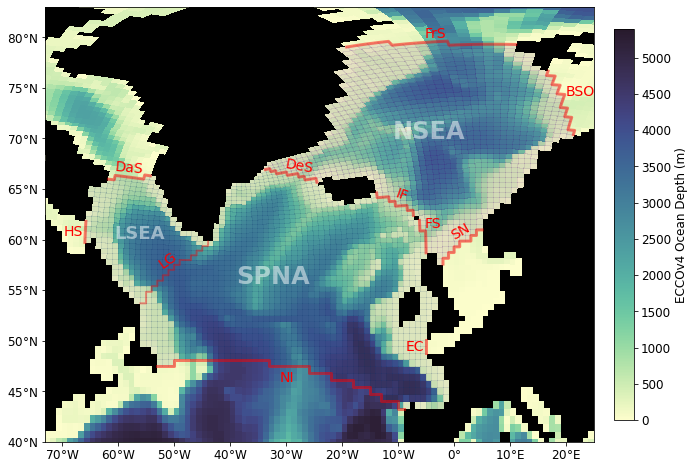

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

p=main.Depth[2].where(main.hFacC[0,2].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.deep)
main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.deep)
main.Depth[6,:73,:30].where(main.hFacC[0,6,:73,:30].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                                    vmin=0, vmax=5400, cmap=cmo.deep)
main.Depth[6,60:,10:70].where(main.hFacC[0,6,60:,10:70].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                                        vmin=0, vmax=5400, cmap=cmo.deep)

main.mask_spna[2].where(main.mask_spna[2].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                          vmin=0, vmax=1, cmap='Blues',alpha=0.1)
main.mask_spna[10].where(main.mask_spna[10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                            vmin=0, vmax=1, cmap='Blues',alpha=0.1)

#main.mask_lsea[10].where(main.mask_lsea[10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
#                                                            vmin=0, vmax=1, cmap='Reds',alpha=0.3)

main.mask_nsea[2].where(main.mask_nsea[2].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                          vmin=0, vmax=1, cmap='Purples',alpha=0.1)
main.mask_nsea[10].where(main.mask_nsea[10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                            vmin=0, vmax=1, cmap='Purples',alpha=0.1)
main.mask_nsea[6,:73,:30].where(main.mask_nsea[6,:73,:30].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                                          vmin=0, vmax=1, cmap='Purples',alpha=0.1)

#maskC_tot[2].where(maskC_tot[2].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
#                                                vmin=0,vmax=1,cmap=plt.cm.Reds,alpha=0.5)
#maskC_tot[10].where(maskC_tot[10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
#                                                vmin=0,vmax=1,cmap=plt.cm.Reds,alpha=0.5)
#maskC_tot[6,:73,:30].where(maskC_tot[6,:73,:30].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
#                                                                vmin=0,vmax=1,cmap=plt.cm.Reds,alpha=0.5)

plt.plot(coords_SB[0::2], coords_SB[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_EC[0::2], coords_EC[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_FS[0::2], coords_FS[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_IF[0::2], coords_IF[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_DeS[0::2], coords_DeS[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_DaS[0::2], coords_DaS[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_HS[0::2], coords_HS[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_FrS[0::2], coords_FrS[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_SvN[0::2], coords_SvN[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_SN[0::2], coords_SN[1::2], color='r',ls='-',lw=3,alpha=0.5)
plt.plot(coords_LG[0::2], coords_LG[1::2], color='r',ls='-',lw=2,alpha=0.4)

#plt.plot(coords_spna[0::2], coords_spna[1::2],'b-')
#plt.plot(coords_nsea[0::2], coords_nsea[1::2],color='purple',ls='-')
#plt.plot(coords_lsea[0::2], coords_lsea[1::2],'r-')

#plt.plot(coords_HS_to_SB[0::2], coords_HS_to_SB[1::2],marker='d',ls='none',ms=2)

j = maskW_tot[2].where((maskW_tot[2].values!=0)&(main.hFacW[0,2].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().j.values
i_g = maskW_tot[2].where((maskW_tot[2].values!=0)&(main.hFacW[0,2].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().i_g.values
#plt.plot(main.XG.isel(tile=2).values[j,i_g],main.YC.isel(tile=2).values[j,i_g],
#         c='r',marker='d',ls='none',ms=2)#

j_g = maskS_tot[2].where((maskS_tot[2].values!=0)&(main.hFacS[0,2].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().j_g.values
i = maskS_tot[2].where((maskS_tot[2].values!=0)&(main.hFacS[0,2].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().i.values
#plt.plot(main.XC.isel(tile=2).values[j_g,i],main.YG.isel(tile=2).values[j_g,i],
#         c='r',marker='d',ls='none',ms=2)

j = maskW_tot[10].where((maskW_tot[10].values!=0)&(main.hFacW[0,10].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().j.values
i_g = maskW_tot[10].where((maskW_tot[10].values!=0)&(main.hFacW[0,10].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().i_g.values
#plt.plot(main.XC.isel(tile=10).values[j,i_g],main.YG.isel(tile=10).values[j,i_g],
#         c='r',marker='d',ls='none',ms=2)

j_g = maskS_tot[10].where((maskS_tot[10].values!=0)&(main.hFacS[0,10].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().j_g.values
i = maskS_tot[10].where((maskS_tot[10].values!=0)&(main.hFacS[0,10].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().i.values
#plt.plot(main.XG.isel(tile=10).values[j_g,i],main.YC.isel(tile=10).values[j_g,i],
#         c='r',marker='d',ls='none',ms=2)

j = maskW_tot[6].where((maskW_tot[6].values!=0)&(main.hFacW[0,6].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().j.values
i_g = maskW_tot[6].where((maskW_tot[6].values!=0)&(main.hFacW[0,6].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().i_g.values
#plt.plot(main.XC.isel(tile=6).values[j,i_g],main.YG.isel(tile=6).values[j,i_g],
#         c='r',marker='d',ls='none',ms=2)

j_g = maskS_tot[6].where((maskS_tot[6].values!=0)&(main.hFacS[0,6].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().j_g.values
i = maskS_tot[6].where((maskS_tot[6].values!=0)&(main.hFacS[0,6].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().i.values
#plt.plot(main.XG.isel(tile=6).values[j_g,i],main.YC.isel(tile=6).values[j_g,i],
#         c='r',marker='d',ls='none',ms=2)

ax.set_xlim([-73,25])
ax.set_ylim([40,83])
ax.set_xticks(np.arange(-70,30,10))
ax.set_yticks(np.arange(40,85,5))

ax.set_xticklabels([r'70$\degree$W',r'60$\degree$W',r'50$\degree$W',r'40$\degree$W',r'30$\degree$W',
                    r'20$\degree$W',r'10$\degree$W',r'0$\degree$',r'10$\degree$E',r'20$\degree$E'], fontsize=12)
ax.set_yticklabels((r'${:.0f}\degree$N'.format(_) for _ in np.arange(40,85,5)), fontsize=12)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_facecolor('k')

ax.text(gdf_spna.geometry.centroid.x[0],gdf_spna.geometry.centroid.y[0], 'SPNA', 
        horizontalalignment='center',verticalalignment='center',fontsize=24, color='w',fontweight='bold',alpha=0.5)
ax.text(gdf_nsea.geometry.centroid.x[0],gdf_nsea.geometry.centroid.y[0], 'NSEA', 
        horizontalalignment='center',verticalalignment='center',fontsize=24, color='w',fontweight='bold',alpha=0.5)
ax.text(gdf_lsea.geometry.centroid.x[0],gdf_lsea.geometry.centroid.y[0], 'LSEA', 
        horizontalalignment='center',verticalalignment='center',fontsize=18, color='w',fontweight='bold',alpha=0.5)

ax.text(np.mean(coords_SB[0::2]),np.mean(coords_SB[1::2])+0.3, 'NI', 
        horizontalalignment='center',verticalalignment='top', fontsize=14, color='r')
ax.text(np.mean(coords_EC[0::2])-0.3,np.mean(coords_EC[1::2]), 'EC', 
        horizontalalignment='right',verticalalignment='center', fontsize=14, color='r')
ax.text(np.mean(coords_SvN[0::2])+0.6,np.mean(coords_SvN[1::2])+1.1, 'BSO', 
        horizontalalignment='left',verticalalignment='center', fontsize=14, color='r')
ax.text(np.mean(coords_FrS[0::2])+1,np.mean(coords_FrS[1::2])+0.3, 'FrS', 
        horizontalalignment='center',verticalalignment='bottom', fontsize=14, color='r')
ax.text(np.mean(coords_SN[0::2]),np.mean(coords_SN[1::2])+0.3, 'SN', 
        horizontalalignment='center',verticalalignment='bottom', rotation=30, fontsize=14, color='r')
ax.text(np.mean(coords_FS[0::2])+0.2,np.mean(coords_FS[1::2])+1.2, 'FS', 
        horizontalalignment='left',verticalalignment='center', fontsize=14, color='r')
ax.text(np.mean(coords_IF[0::2])+1,np.mean(coords_IF[1::2]), 'IF', 
        horizontalalignment='center',verticalalignment='bottom', rotation=-20, fontsize=14, color='r')
ax.text(np.mean(coords_DeS[0::2])+1.5,np.mean(coords_DeS[1::2])-0.1, 'DeS', 
        horizontalalignment='center',verticalalignment='bottom', rotation=-10, fontsize=14, color='r')
ax.text(np.mean(coords_DaS[0::2]),np.mean(coords_DaS[1::2])+0.1, 'DaS', 
        horizontalalignment='center',verticalalignment='bottom', rotation=-5, fontsize=14, color='r')
ax.text(coords_HS[0]-0.5,np.mean(coords_HS[1::2]), 'HS', 
        horizontalalignment='right',verticalalignment='center',fontsize=14, color='r')
ax.text(np.mean(coords_LG[0::2])-1,np.mean(coords_LG[1::2]), 'LG', 
        horizontalalignment='center',verticalalignment='bottom', rotation=35, fontsize=14, color='r')
cbar = fig.colorbar(p, ax=ax, ticks=np.arange(0,5500,500),shrink=0.9, pad = 0.03)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'ECCOv4 Ocean Depth (m)', fontsize=12)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

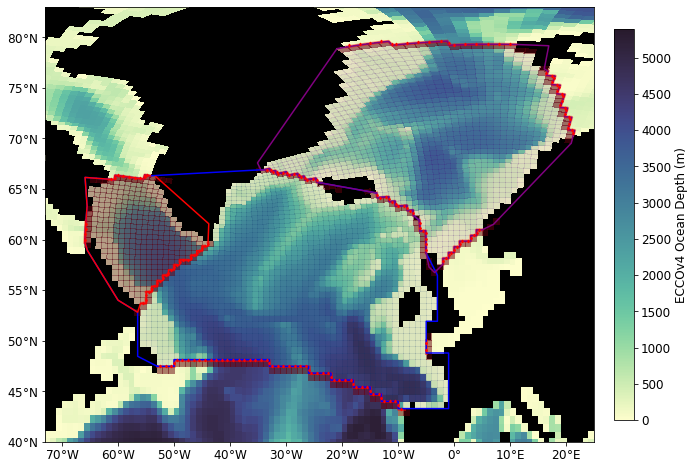

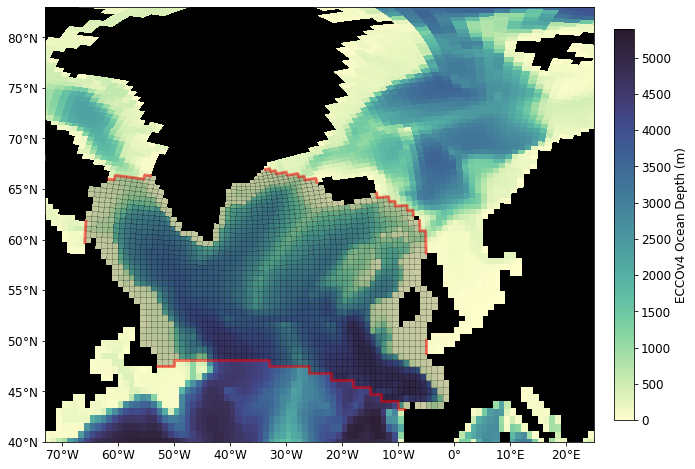

In [7]:
ptBS1,ptBS2 = ecco.get_section_endpoints('Bering Strait')
maskC_BS, maskW_BS, maskS_BS = ecco.get_section_line_masks(ptBS1,ptBS2,main)

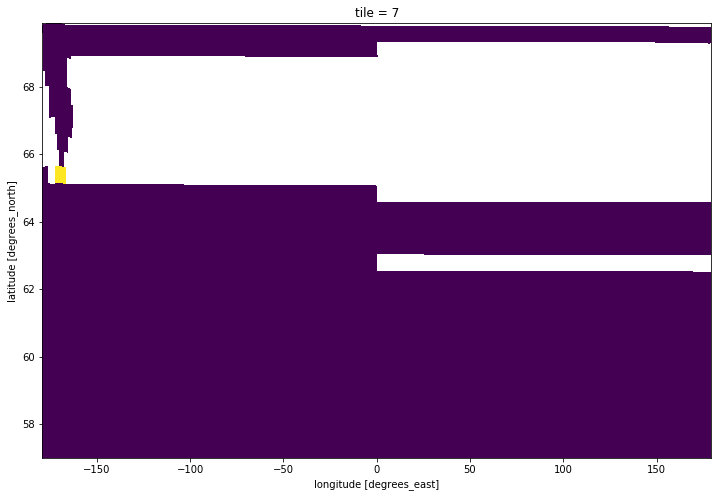

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

maskC_BS[7,10:60,5:30].where((main.hFacC[0,7,10:60,5:30].values==1)).plot(ax=ax, x='XC', y='YC', add_colorbar=False)

/usr/local/lib/python3.6/dist-packages/Cartopy-0.17.1.dev172_-py3.6-linux-x86_64.egg/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)
/usr/local/lib/python3.6/dist-packages/Cartopy-0.17.1.dev172_-py3.6-linux-x86_64.egg/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


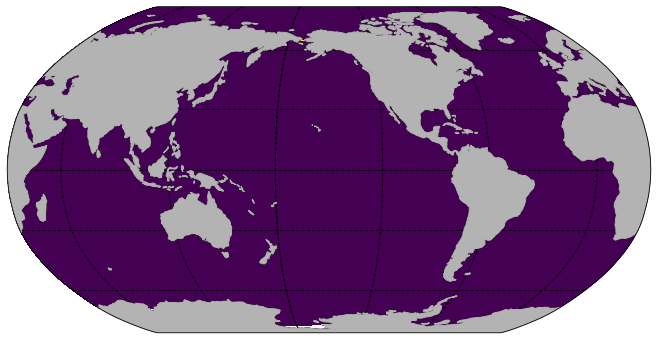

In [30]:
plt.figure(figsize=(12,6))
fig,ax,p,cb = ecco.plot_proj_to_latlon_grid(main.XC,main.YC,maskC_BS,cmap='viridis',projection_type='robin',user_lon_0=-150)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
plt.show()

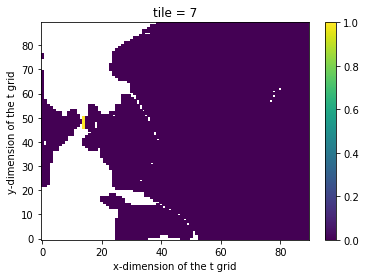

In [19]:
maskC_BS[7].where(main.hFacC[0,7].values==1).plot()

### Methodology: Get coordinates for each section

In [22]:
print(j,i_g)
#print(j_g,i)	

[72 73 74 75 76 77 78 79 80 81 82 83] [36 34 33 32 31 30 29 28 28 27 26 25]


In [123]:
print(main.XG[10,73,10].values,',',main.YG[10,73,10].values,',')

-53.250584 , 66.21951 ,


(45, 75)

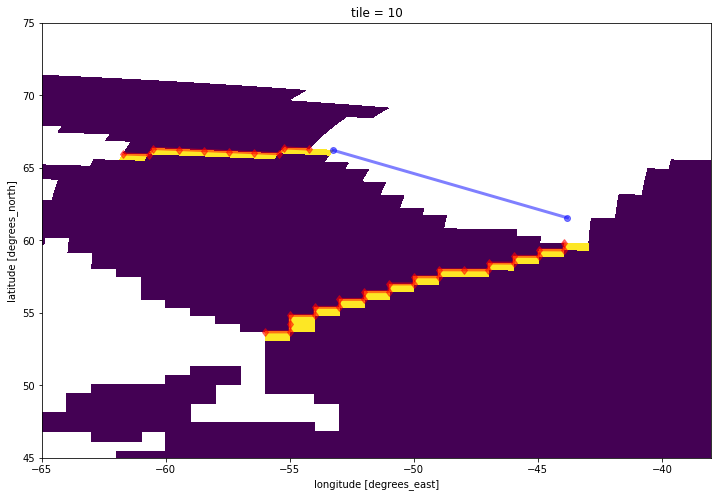

In [125]:
fig, ax = plt.subplots(figsize=(12,8))
maskC_DaS[10].where((main.hFacC[0,10].values==1)).plot(ax=ax, x='XC', y='YC', add_colorbar=False)
maskC_LG[10].where((main.hFacC[0,10].values==1)&(maskC_LG[10].values==1)).plot(ax=ax, x='XC', y='YC',vmin=0,
                                                                             add_colorbar=False)

plt.plot(coords_LG[0::2], coords_LG[1::2], color='r',ls='-',lw=3,alpha=0.5,marker='d')
plt.plot(coords_DaS[0::2], coords_DaS[1::2], color='r',ls='-',lw=3,alpha=0.5,marker='d')
plt.plot(coords_LG_to_DaS[0::2], coords_LG_to_DaS[1::2], color='b',ls='-',lw=3,alpha=0.5,marker='o')


ax.set_xlim([-65,-38])
ax.set_ylim([45,75])

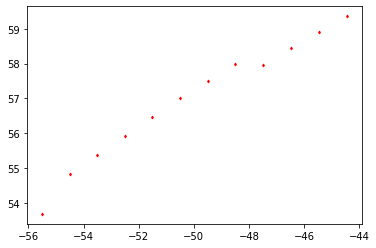

In [20]:
j = maskW_LG[10].where((maskW_LG[10].values!=0)&(main.hFacW[0,10].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().j.values
i_g = maskW_LG[10].where((maskW_LG[10].values!=0)&(main.hFacW[0,10].values==1))\
        .to_dataframe(name='maskW').dropna().reset_index().i_g.values
plt.plot(main.XC.isel(tile=10).values[j,i_g],main.YG.isel(tile=10).values[j,i_g],
         c='r',marker='d',ls='none',ms=2)

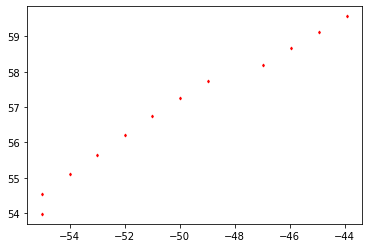

In [98]:
j_g = maskS_LG[10].where((maskS_LG[10].values!=0)&(main.hFacS[0,10].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().j_g.values
i = maskS_LG[10].where((maskS_LG[10].values!=0)&(main.hFacS[0,10].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().i.values
plt.plot(main.XG.isel(tile=10).values[j_g,i],main.YC.isel(tile=10).values[j_g,i],
         c='r',marker='d',ls='none',ms=2)

In [30]:
main.XG.isel(tile=10).values[j,i_g]
#maskC_SB, maskW_SB, maskS_SB

array([-56.      , -55.      , -54.      , -53.      , -52.      ,
       -51.      , -49.997044, -48.98871 , -47.98942 , -46.9778  ,
       -45.9637  , -44.94873 ], dtype=float32)

In [31]:
main.YG.isel(tile=10).values[j,i_g]

array([53.69125 , 54.829044, 55.384766, 55.931786, 56.470177, 57.      ,
       57.494728, 57.978825, 57.972424, 58.443645, 58.905373, 59.35802 ],
      dtype=float32)

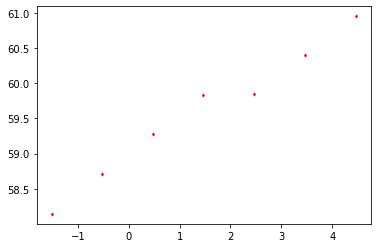

In [275]:
j_g = maskS_SN[2].where((maskS_SN[2].values!=0)&(main.hFacS[0,2].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().j_g.values
i = maskS_SN[2].where((maskS_SN[2].values!=0)&(main.hFacS[0,2].values==1))\
        .to_dataframe(name='maskS').dropna().reset_index().i.values

plt.plot(main.XC.isel(tile=2).values[j_g,i],main.YG.isel(tile=2).values[j_g,i],
         c='r',marker='d',ls='none',ms=2)

In [116]:
maskC_DaS[10].where(maskC_DaS[10].values!=0).to_dataframe(name='maskC').dropna().reset_index()

,j,i,CS,Depth,SN,XC,YC,tile,rA,maskC
0,62,12,-0.126573,0.000000,-0.991957,-64.387535,65.886246,10,2.443123e+09,1.0
1,63,12,-0.132371,0.000000,-0.991200,-63.348080,65.830742,10,2.424104e+09,1.0
2,64,12,-0.137887,0.000000,-0.990448,-62.312744,65.772873,10,2.403745e+09,1.0
3,65,12,-0.143091,266.052124,-0.989710,-61.281780,65.712769,10,2.382007e+09,1.0
4,66,11,-0.159469,495.733826,-0.987203,-60.088505,66.089531,10,2.300975e+09,1.0
5,67,11,-0.164425,573.443909,-0.986390,-59.063908,66.021286,10,2.275844e+09,1.0
6,68,11,-0.168949,580.323303,-0.985625,-58.045128,65.951195,10,2.249115e+09,1.0
7,69,11,-0.172994,592.159973,-0.984923,-57.032475,65.879486,10,2.220741e+09,1.0
8,70,11,-0.176506,506.124298,-0.984300,-56.026276,65.806404,10,2.190686e+09,1.0
9,71,10,-0.193872,126.269997,-0.981027,-54.836185,66.141624,10,2.099787e+09,1.0
